### Aggiunta Librerie

In [2]:
import datetime as datetime
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
start_date = datetime.datetime(1990, 11, 1)
end_date = datetime.datetime.now()

start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

### Scraping dati

In [4]:
# Prendo i ticker che mi interessano

# leggo il file csv con i ticker
df = pd.read_csv("sp500_tickers.csv")
tickers = df["Ticker"].tolist()

# prendo solo i primi 5 tickers
tickers = tickers[:6]

tickers = ["AAPL", "MSFT", "AMZN", "JPM", "WMT"]

In [5]:
# Scarico i dati dei tickers

# Setta questa variabile a True se vuoi scaricare i dati anche se già presenti
force_download = False

for ticker in tickers:
    try:
        #controllo se il file già esiste e in caso lo salto
        if f"{ticker}.csv" in os.listdir("stocks") and not force_download:
            print(f"{ticker} già scaricato")
            continue
        data = yf.download(ticker, start=start_date_str, end=end_date_str, period="1d")
        data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]
        data.to_csv(f"stocks/{ticker}.csv")
    except Exception as e:
        print(f"Errore durante il download di {ticker}: {e}")


AAPL già scaricato
MSFT già scaricato
AMZN già scaricato
JPM già scaricato
WMT già scaricato


In [6]:
# Prendo i csv i li metto in una lista di dataframe
stocks = {}
for ticker in tickers:
    try:
        df = pd.read_csv(f"stocks/{ticker}.csv")
        stocks[ticker] = df
    except Exception as e:
        print(f"Errore durante la lettura di {ticker}: {e}")

## Tassi di rendimento

In [7]:
# Funzione per graficare i tassi di rendimento
def plot_ret_rate(df, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['return'], label='Return')
    plt.title(title, fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Return", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # Mostra il grafico
    plt.show()

### Tassi di rendimenti logaritmici giornalieri

In [8]:
# calcolo i rendimenti logaritmici giornalieri per tutte le stocks a partire dai prezzi di chiusura e li metto in un' altra lista di dataframe
log_daily_ret_rates = {}
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret["return"] = np.log(p_t / p_t_1)
    log_daily_ret_rates[ticker] = ret
    #print(ret.head)


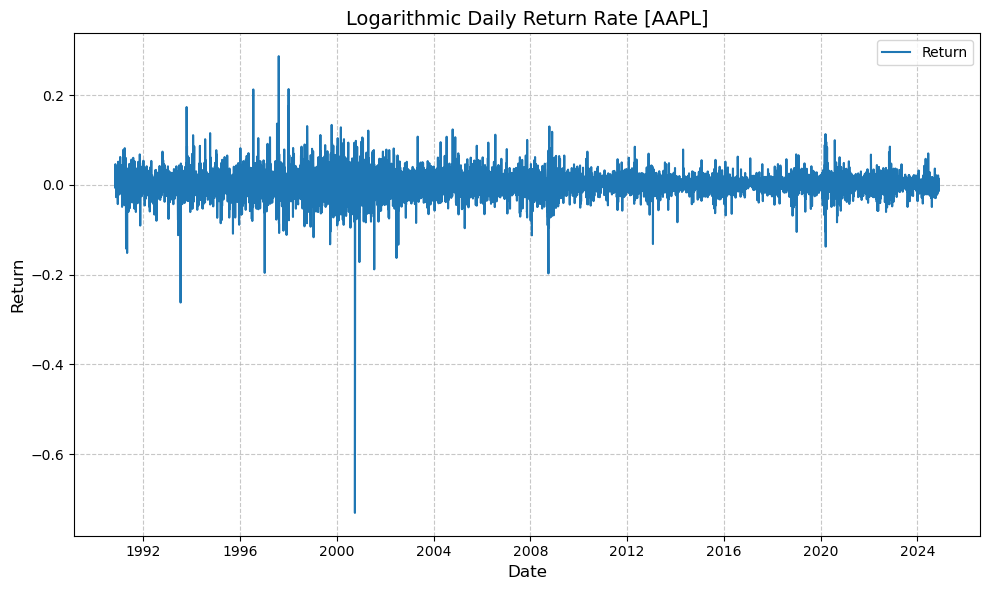

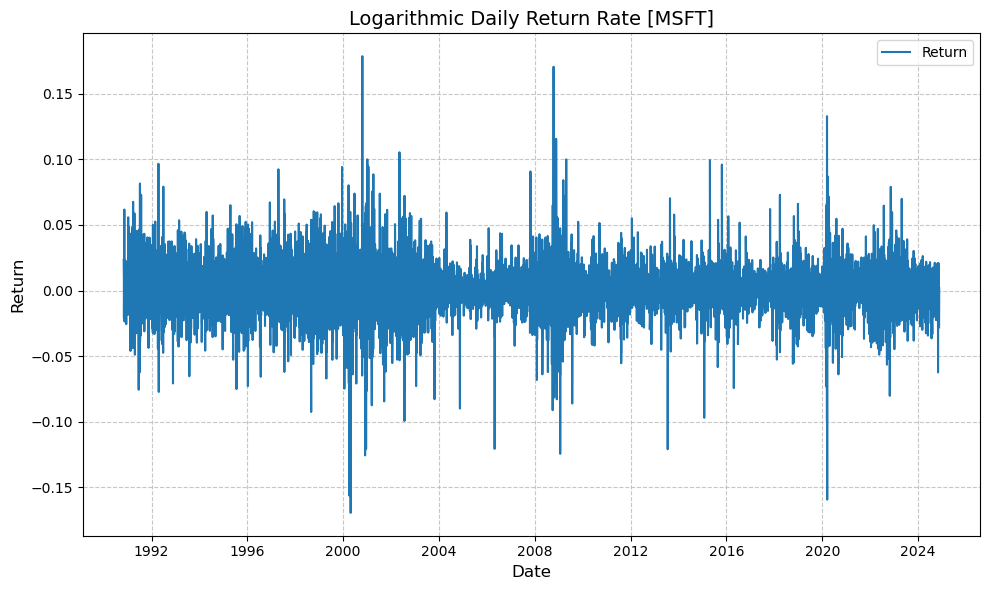

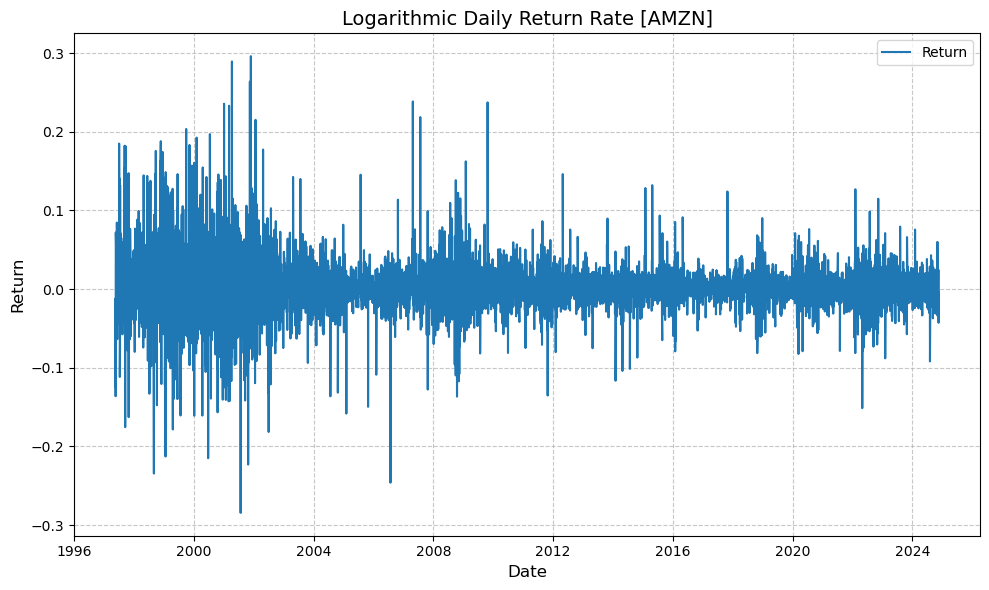

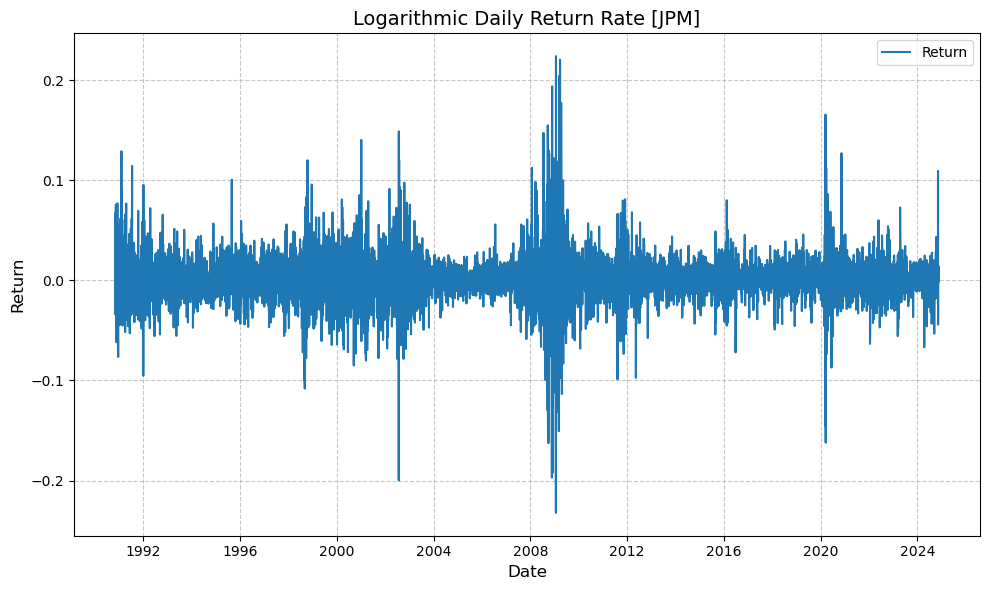

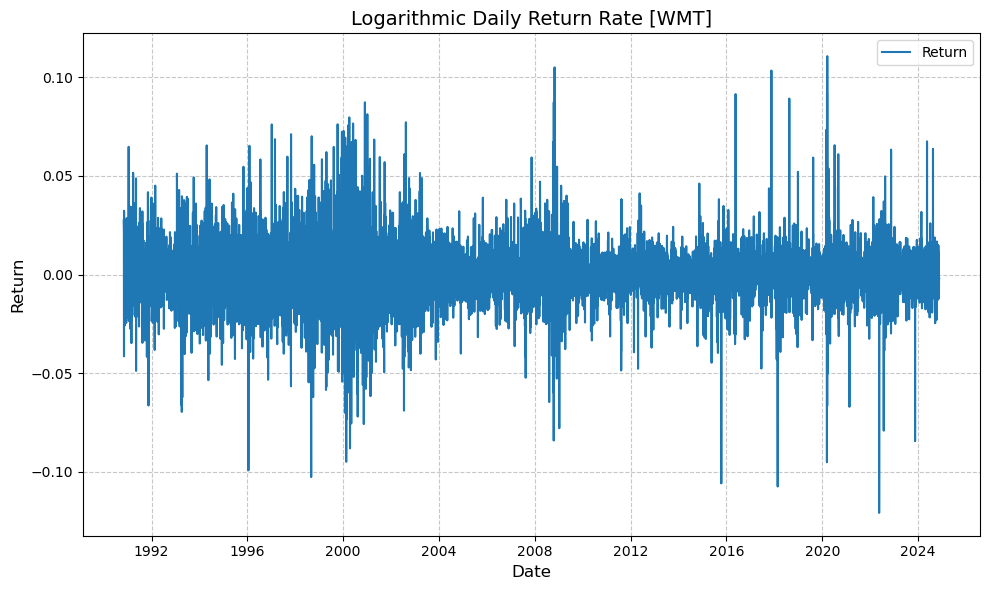

In [9]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in log_daily_ret_rates.items():
    plot_ret_rate(ret, "Logarithmic Daily Return Rate [" + ticker + "]")

### Tassi di rendimento settimanali

In [10]:
weekly_ret_rates = {}
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Week"] = ret["Date"].dt.to_period("W")
    ret = ret.groupby("Week").first().reset_index()
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret["return"] = (p_t - p_t_1)/p_t_1
    weekly_ret_rates[ticker] = ret

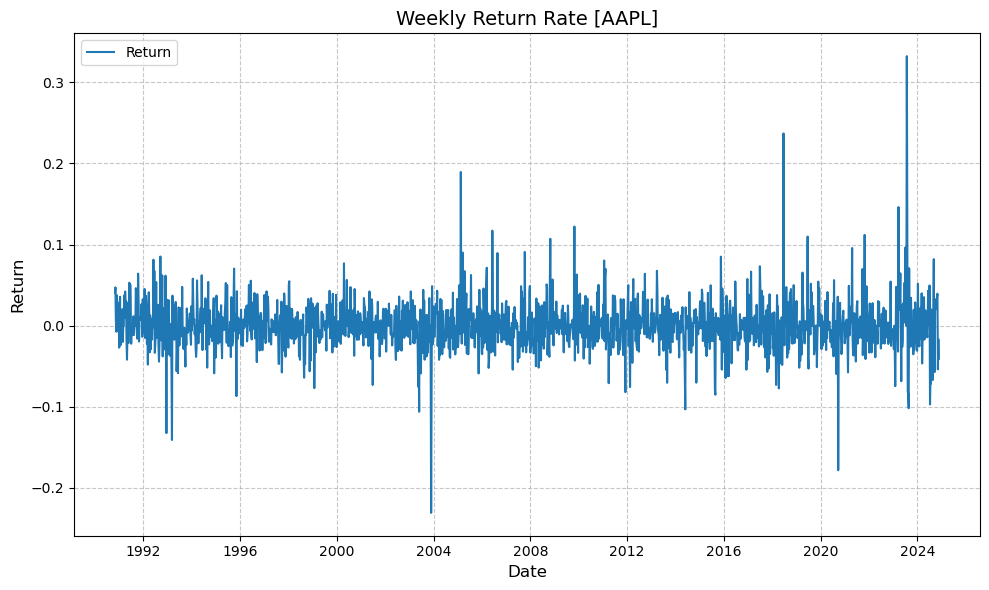

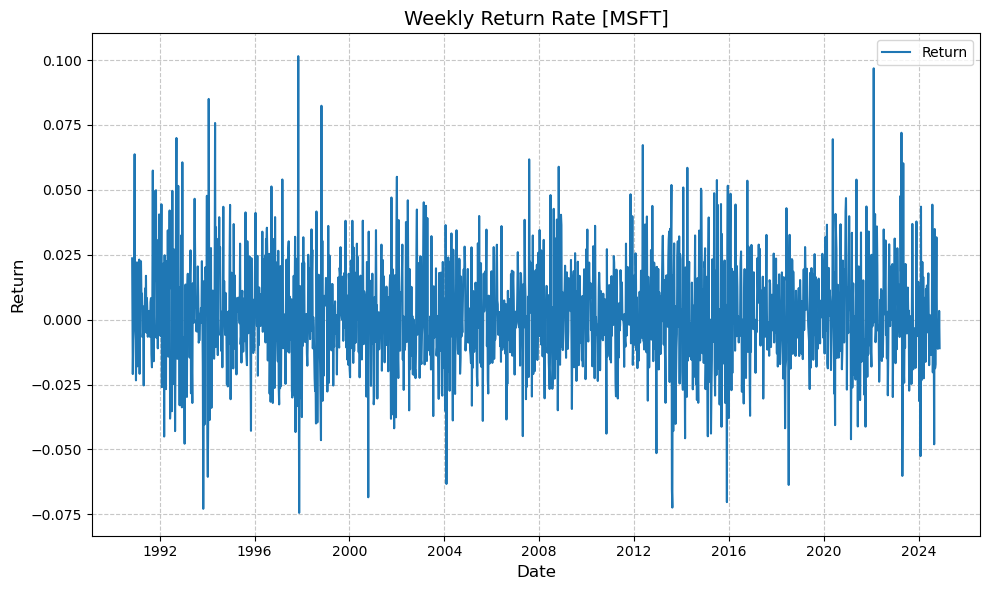

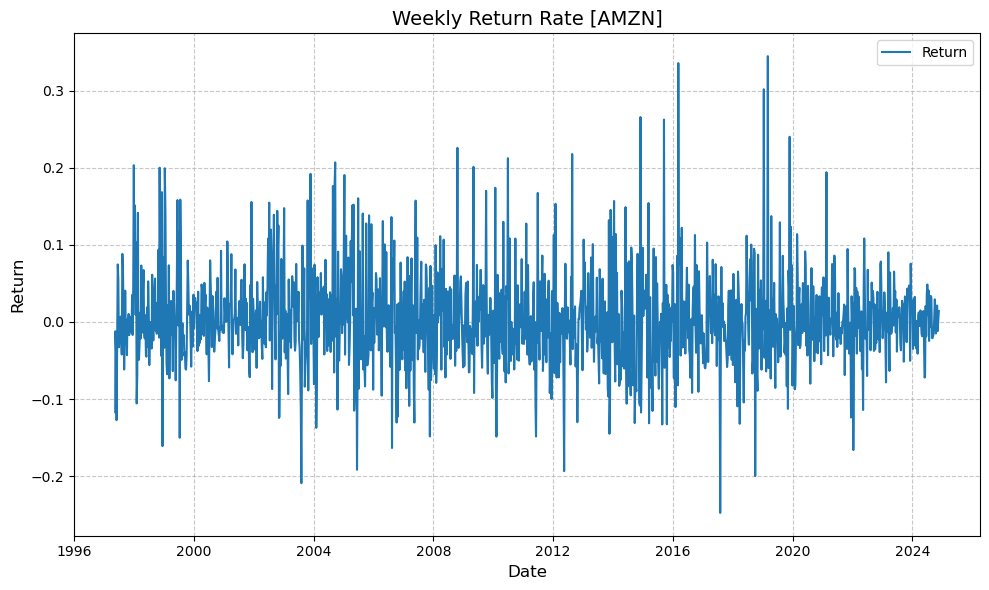

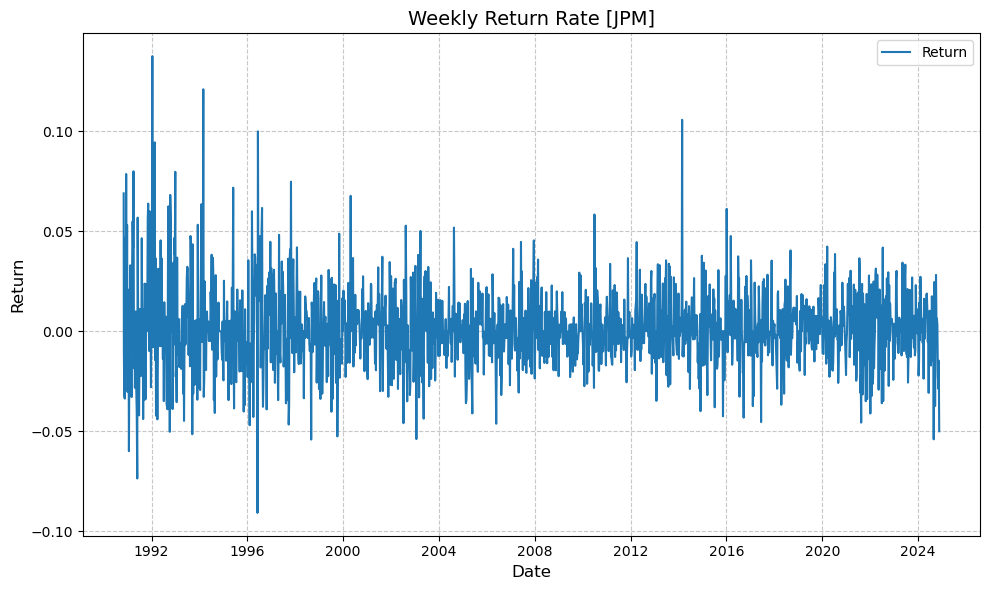

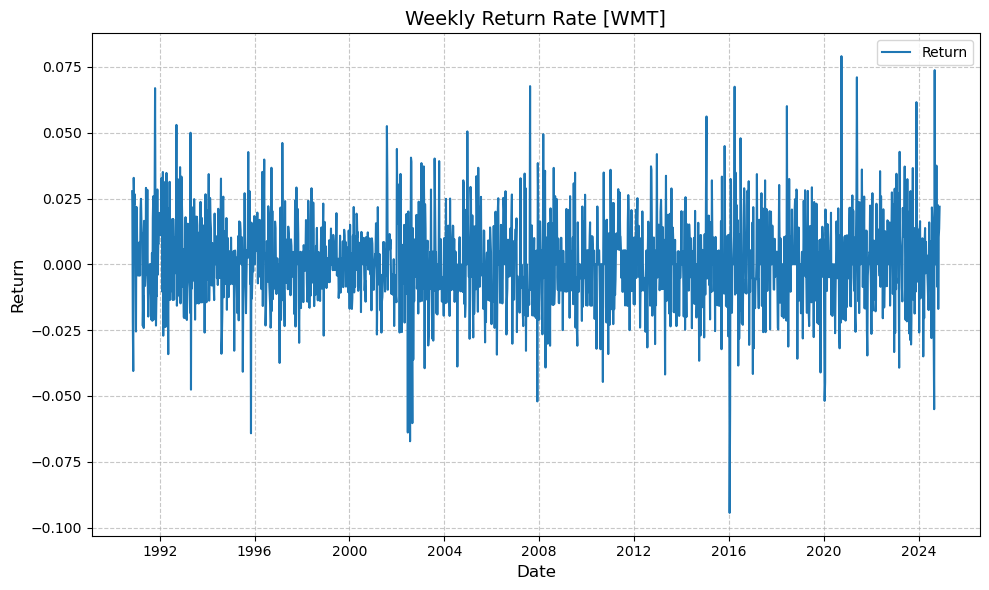

In [11]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in weekly_ret_rates.items():
    plot_ret_rate(ret, "Weekly Return Rate [" + ticker + "]")

### Tassi di rendimento mensili

In [12]:
monthly_ret_rates = {}
for ticker, stock in stocks.items():
    ret = pd.DataFrame()
    ret["Date"] = pd.to_datetime(stock["Date"].shift(-1)[:-1])
    ret["Date"] = ret["Date"].dt.tz_localize(None)
    ret["Month"] = ret["Date"].dt.to_period("M")
    ret = ret.groupby("Month").first().reset_index()
    p_t = stock["Close"].shift(-1)[:-1]
    p_t_1 = stock["Close"][:-1] 
    ret["return"] = (p_t - p_t_1)/p_t_1
    monthly_ret_rates[ticker] = ret

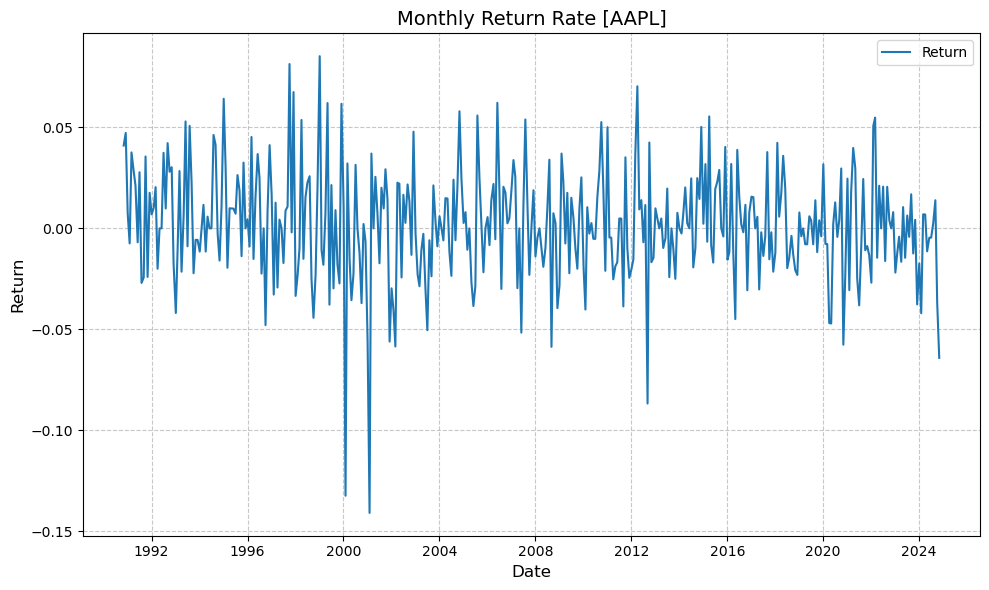

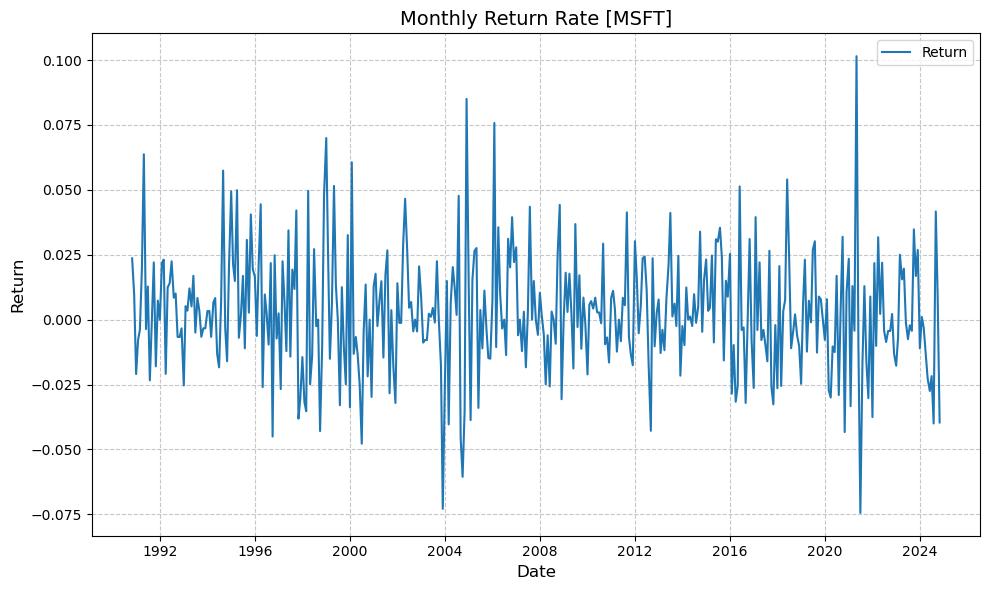

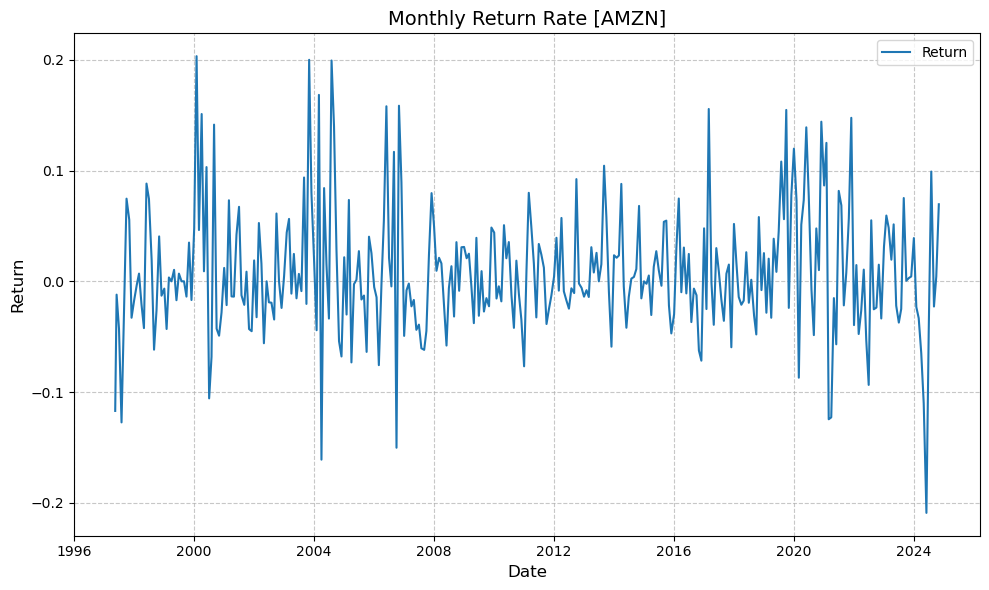

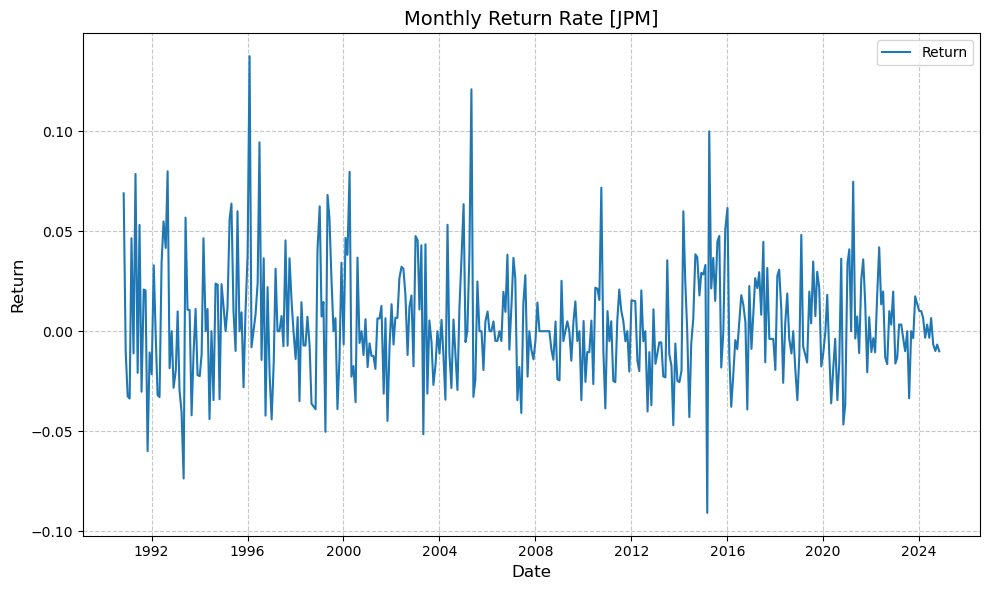

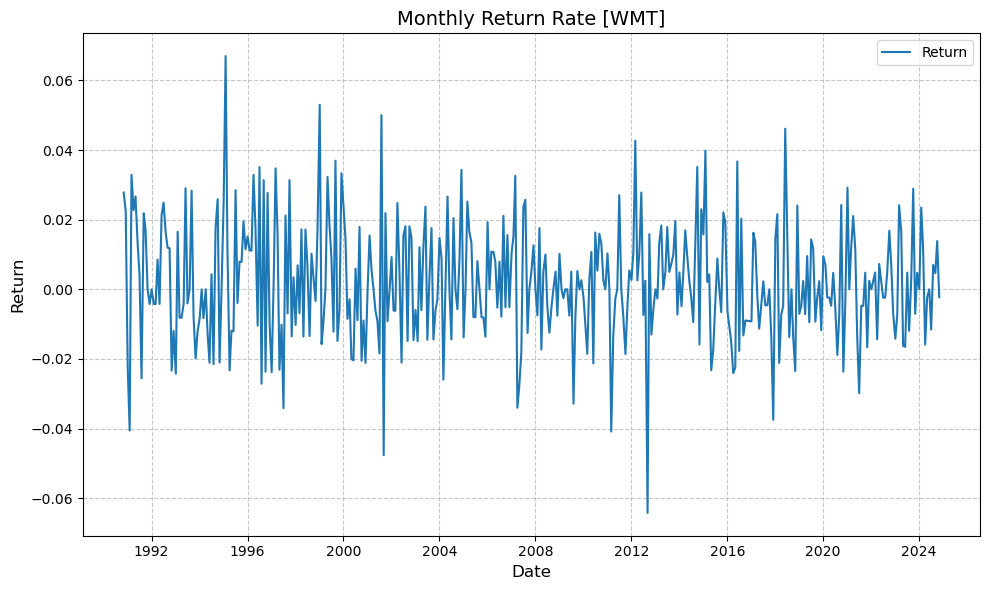

In [13]:
# Faccio il grafico di tutti i ritorni per ogni stock

for ticker, ret in monthly_ret_rates.items():
    plot_ret_rate(ret, "Monthly Return Rate [" + ticker + "]")

## Frontiera efficiente

### Matrice Varianza-Covarianza

In [14]:
# Unisco i dati delle varie stock in un unico dataframe
all_stocks = pd.DataFrame()
for ticker, stock in stocks.items():
    df = pd.DataFrame()
    df = stock.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    df = df.rename(columns={"Close": ticker})
    all_stocks = pd.concat([all_stocks, df[ticker]], axis=1)

#Elimino tutte le righe che contengono NaN
all_stocks.dropna(inplace=True)

# Costruisco la matrice di covarianza
print(all_stocks.cov())

             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3298.977635   5884.413214  3015.059491  2346.507317   747.724783
MSFT  5884.413214  10821.428857  5484.123325  4300.542912  1344.817741
AMZN  3015.059491   5484.123325  3099.148482  2319.367162   713.282203
JPM   2346.507317   4300.542912  2319.367162  1924.364598   560.891193
WMT    747.724783   1344.817741   713.282203   560.891193   186.507057


### Tassi di rendimento per le stock

In [15]:
# Calcolo del tasso di rendimento per ogni stock
stock_return = pd.DataFrame()
# Calcolo il tasso di rendimento come il valore finale meno il valore iniziale diviso il valore iniziale
stock_return["Return"] = (all_stocks.iloc[-1] - all_stocks.iloc[0]) / all_stocks.iloc[0]
print(stock_return)

           Return
AAPL  1437.775406
MSFT    27.397695
AMZN  2058.907893
JPM      6.568494
WMT     15.540329


### Insieme dei portafogli fattibili

In [42]:
# Creo un dataframe in cui faccio variare la combinazione dei pesi delle azioni
wallets = pd.DataFrame()
# creo una colonna per ogni peso
for ticker in tickers:
    # faccio 100 estrazioni casuali tra 0 e 1
    wallets[ticker] = np.random.rand(1000)

# Normalizzo i pesi
wallets = wallets.div(wallets.sum(axis=1), axis=0)

# Calcolo il rendimento atteso pesando i rendimenti delle azioni per i pesi
wallets_return = (wallets * stock_return["Return"]).sum(axis=1)

# Calcolo la varianza pesata
cov = all_stocks.cov()
print(cov)
wallets_variance = wallets.apply(lambda x: np.sqrt(np.dot(x, np.dot(cov, x))), axis=1)

# Unisco i dati in un unico dataframe
wallets["Return"] = wallets_return
wallets["Risk"] = wallets_variance
print(wallets)


             AAPL          MSFT         AMZN          JPM          WMT
AAPL  3298.977635   5884.413214  3015.059491  2346.507317   747.724783
MSFT  5884.413214  10821.428857  5484.123325  4300.542912  1344.817741
AMZN  3015.059491   5484.123325  3099.148482  2319.367162   713.282203
JPM   2346.507317   4300.542912  2319.367162  1924.364598   560.891193
WMT    747.724783   1344.817741   713.282203   560.891193   186.507057
         AAPL      MSFT      AMZN       JPM       WMT       Return       Risk
0    0.271696  0.153370  0.072455  0.118879  0.383599   550.760658  45.312707
1    0.046467  0.229217  0.247887  0.101722  0.374707   589.956722  49.012799
2    0.242344  0.304752  0.127092  0.285009  0.040803   620.962691  64.754182
3    0.285038  0.108438  0.122000  0.237112  0.247413   669.379770  47.313662
4    0.090808  0.426173  0.190524  0.238099  0.054395   536.919652  70.348044
..        ...       ...       ...       ...       ...          ...        ...
995  0.000232  0.102622  0.3

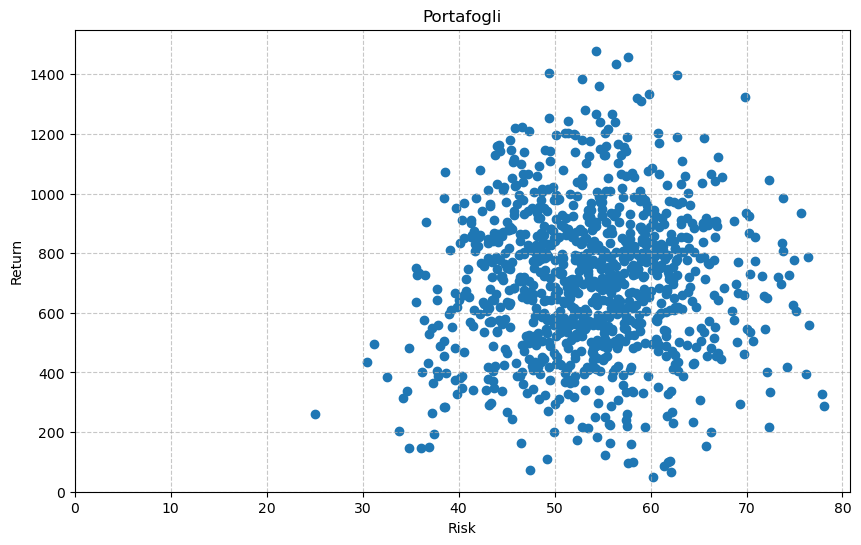

In [43]:
# Grafico i vari portafogli con uno scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(wallets["Risk"], wallets["Return"], alpha=1)
plt.title("Portafogli")
plt.xlabel("Risk")
plt.ylabel("Return")
plt.xlim(0)
plt.ylim(0)
# mostro il grafico il scala logaritmica
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()